---
title: "Multi-stage Spectral-wise Transformer for Efficient Spectral Reconstruction (CVPRW 2022)"
description: "HSI"
author: 
 - name: "Leila Mozaffari"
   email: leila.mozaffari@ninjalabo.ai
date: "12/12/2024"
draft: false
categories:
  - Tech
---

# MST++: Multi-stage Spectral-wise Transformer for Efficient Spectral Reconstruction (CVPRW 2022)

This work was a winner at the Spectral Reconstruction Challenge  2022- NTIRE.

* GitHub link: https://github.com/caiyuanhao1998/MST-plus-plus/tree/master <br>
This repo is a baseline and toolbox containing 11 image restoration algorithms for Spectral Reconstruction.

* Paper Link: https://arxiv.org/abs/2204.07908


* Dataset: https://github.com/boazarad/ARAD_1K


Hyperspectral imaging (HSI), captures the spectral information of a scene across multiple wavelengths, making it much richer than regular RGB images. HSI has widespread applications in fields like medical imaging, remote sensing, and environmental monitoring.
Traditional methods for HSI need expensive hardware and are time-intensive, which limits their use in dynamic or real-time scenarios.
This work aims to generate high-quality HSIs from RGB images.
Current approaches using convolutional neural networks (CNNs) which perform well but face different challenges:
* They struggle to model long-range dependencies.
* They fail to effectively capture self-similarity within the spectral data.

In order to address these limitations, the authors introduce MST++, a Transformer-based framework for spectral reconstruction.

  

## Pipeline of MST++ Model Architecture
* a) MST++: Multi-stage Spectral-wise Transformer
* b) SST: Single-stage Spectral-wise Transformer
* c) SAB: Spectral-wise Attention Block
* d) FFN: Feed Forward Network
* e) S-MSA: Spectral-wise Multi-head Self-attention


![](images/MST.png)

## Dataset:

**ARAD_1K**, The dataset provided by NTIRE 2022 Spectral Reconstruction Challenge contains 1000 RGB-HSI pairs. This dataset is split into train, valid, and test subsets in proportional to 18:1:1. Each HSI at size of 482×512 has 31 wavelengths from 400 nm to 700 nm.

This data set contains 950 publicly images and 50 “test” images which have only been released as RGB or Multi-Spectral-Filter-Array “RAW” files.

Publicly available images have been published as:

* 31 channel hyperspectral images in the 400-700nm range
* 16 channel multi-spectral images in the 400-1000nm range

## 1. Create Envirement:

* Python 3 (Recommend to use Anaconda)

* NVIDIA GPU + CUDA

* Python packages : requirements.txt

## 2. Data Preparation:

Download datasets from the main GitHub repo.
* training spectral images (Google Drive / Baidu Disk, code: mst1): Size 19G
* training RGB images (Google Drive / Baidu Disk): Size 22M
* validation spectral images (Google Drive / Baidu Disk): Size 1G
* validation RGB images (Google Drive / Baidu Disk): Size 1M
* testing RGB images (Google Drive / Baidu Disk): Size 1M 

## Directory of the dataset:
* Place the training spectral images and validation spectral images to /MST-plus-plus/dataset/Train_Spec/.

* Place the training RGB images and validation RGB images to /MST-plus-plus/dataset/Train_RGB/.

* Place the testing RGB images to /MST-plus-plus/dataset/Test_RGB/.

Then this repo is collected as the following form:

In [2]:
#| eval: false
# create environment: conda create -n ostrack python=3.8
# conda activate MST
#cd MST-plus-plus/

In [3]:
#| eval: false
# !pip install -r requirements.txt

## Different Methods:
* **HSCNN+**
* HRNet
* EDSR
* AWAN
* HDNet
* HINet
* MIRNet
* Restormer
* MPRNet
* MST-L
* **MST ++**


#### MST_Plus_Plus

In [33]:
#| eval: false
import torch.nn as nn
import torch
import torch.nn.functional as F
from einops import rearrange
import math
import warnings
from torch.nn.init import _calculate_fan_in_and_fan_out

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)
    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def variance_scaling_(tensor, scale=1.0, mode='fan_in', distribution='normal'):
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    if mode == 'fan_in':
        denom = fan_in
    elif mode == 'fan_out':
        denom = fan_out
    elif mode == 'fan_avg':
        denom = (fan_in + fan_out) / 2
    variance = scale / denom
    if distribution == "truncated_normal":
        trunc_normal_(tensor, std=math.sqrt(variance) / .87962566103423978)
    elif distribution == "normal":
        tensor.normal_(std=math.sqrt(variance))
    elif distribution == "uniform":
        bound = math.sqrt(3 * variance)
        tensor.uniform_(-bound, bound)
    else:
        raise ValueError(f"invalid distribution {distribution}")


def lecun_normal_(tensor):
    variance_scaling_(tensor, mode='fan_in', distribution='truncated_normal')


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)


class GELU(nn.Module):
    def forward(self, x):
        return F.gelu(x)

def conv(in_channels, out_channels, kernel_size, bias=False, padding = 1, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride=stride)


def shift_back(inputs,step=2):          # input [bs,28,256,310]  output [bs, 28, 256, 256]
    [bs, nC, row, col] = inputs.shape
    down_sample = 256//row
    step = float(step)/float(down_sample*down_sample)
    out_col = row
    for i in range(nC):
        inputs[:,i,:,:out_col] = \
            inputs[:,i,:,int(step*i):int(step*i)+out_col]
    return inputs[:, :, :, :out_col]

class MS_MSA(nn.Module):
    def __init__(
            self,
            dim,
            dim_head,
            heads,
    ):
        super().__init__()
        self.num_heads = heads
        self.dim_head = dim_head
        self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
        self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
        self.proj = nn.Linear(dim_head * heads, dim, bias=True)
        self.pos_emb = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
            GELU(),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
        )
        self.dim = dim

    def forward(self, x_in):
        """
        x_in: [b,h,w,c]
        return out: [b,h,w,c]
        """
        b, h, w, c = x_in.shape
        x = x_in.reshape(b,h*w,c)
        q_inp = self.to_q(x)
        k_inp = self.to_k(x)
        v_inp = self.to_v(x)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads),
                                (q_inp, k_inp, v_inp))
        v = v
        # q: b,heads,hw,c
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)
        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)
        attn = (k @ q.transpose(-2, -1))   # A = K^T*Q
        attn = attn * self.rescale
        attn = attn.softmax(dim=-1)
        x = attn @ v   # b,heads,d,hw
        x = x.permute(0, 3, 1, 2)    # Transpose
        x = x.reshape(b, h * w, self.num_heads * self.dim_head)
        out_c = self.proj(x).view(b, h, w, c)
        out_p = self.pos_emb(v_inp.reshape(b,h,w,c).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        out = out_c + out_p

        return out

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1, 1, bias=False),
            GELU(),
            nn.Conv2d(dim * mult, dim * mult, 3, 1, 1, bias=False, groups=dim * mult),
            GELU(),
            nn.Conv2d(dim * mult, dim, 1, 1, bias=False),
        )

    def forward(self, x):
        """
        x: [b,h,w,c]
        return out: [b,h,w,c]
        """
        out = self.net(x.permute(0, 3, 1, 2))
        return out.permute(0, 2, 3, 1)

class MSAB(nn.Module):
    def __init__(
            self,
            dim,
            dim_head,
            heads,
            num_blocks,
    ):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_blocks):
            self.blocks.append(nn.ModuleList([
                MS_MSA(dim=dim, dim_head=dim_head, heads=heads),
                PreNorm(dim, FeedForward(dim=dim))
            ]))

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out: [b,c,h,w]
        """
        x = x.permute(0, 2, 3, 1)
        for (attn, ff) in self.blocks:
            x = attn(x) + x
            x = ff(x) + x
        out = x.permute(0, 3, 1, 2)
        return out

class MST(nn.Module):
    def __init__(self, in_dim=31, out_dim=31, dim=31, stage=2, num_blocks=[2,4,4]):
        super(MST, self).__init__()
        self.dim = dim
        self.stage = stage

        # Input projection
        self.embedding = nn.Conv2d(in_dim, self.dim, 3, 1, 1, bias=False)

        # Encoder
        self.encoder_layers = nn.ModuleList([])
        dim_stage = dim
        for i in range(stage):
            self.encoder_layers.append(nn.ModuleList([
                MSAB(
                    dim=dim_stage, num_blocks=num_blocks[i], dim_head=dim, heads=dim_stage // dim),
                nn.Conv2d(dim_stage, dim_stage * 2, 4, 2, 1, bias=False),
            ]))
            dim_stage *= 2

        # Bottleneck
        self.bottleneck = MSAB(
            dim=dim_stage, dim_head=dim, heads=dim_stage // dim, num_blocks=num_blocks[-1])

        # Decoder
        self.decoder_layers = nn.ModuleList([])
        for i in range(stage):
            self.decoder_layers.append(nn.ModuleList([
                nn.ConvTranspose2d(dim_stage, dim_stage // 2, stride=2, kernel_size=2, padding=0, output_padding=0),
                nn.Conv2d(dim_stage, dim_stage // 2, 1, 1, bias=False),
                MSAB(
                    dim=dim_stage // 2, num_blocks=num_blocks[stage - 1 - i], dim_head=dim,
                    heads=(dim_stage // 2) // dim),
            ]))
            dim_stage //= 2

        # Output projection
        self.mapping = nn.Conv2d(self.dim, out_dim, 3, 1, 1, bias=False)

        #### activation function
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """

        # Embedding
        fea = self.embedding(x)

        # Encoder
        fea_encoder = []
        for (MSAB, FeaDownSample) in self.encoder_layers:
            fea = MSAB(fea)
            fea_encoder.append(fea)
            fea = FeaDownSample(fea)

        # Bottleneck
        fea = self.bottleneck(fea)

        # Decoder
        for i, (FeaUpSample, Fution, LeWinBlcok) in enumerate(self.decoder_layers):
            fea = FeaUpSample(fea)
            fea = Fution(torch.cat([fea, fea_encoder[self.stage-1-i]], dim=1))
            fea = LeWinBlcok(fea)

        # Mapping
        out = self.mapping(fea) + x

        return out

class MST_Plus_Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
        super(MST_Plus_Plus, self).__init__()
        self.stage = stage
        self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2,bias=False)
        modules_body = [MST(dim=31, stage=2, num_blocks=[1,1,1]) for _ in range(stage)]
        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2,bias=False)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        b, c, h_inp, w_inp = x.shape
        hb, wb = 8, 8
        pad_h = (hb - h_inp % hb) % hb
        pad_w = (wb - w_inp % wb) % wb
        x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
        x = self.conv_in(x)
        h = self.body(x)
        h = self.conv_out(h)
        h += x
        return h[:, :, :h_inp, :w_inp]


In [36]:
#| eval: false
# from architecture.mst_plus_plus import MST_Plus_Plus
import architecture
from utils import my_summary
my_summary(MST_Plus_Plus(), 256, 256, 3, 1)

MST_Plus_Plus(
  (conv_in): Conv2d(3, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (body): Sequential(
    (0): MST(
      (embedding): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (encoder_layers): ModuleList(
        (0): ModuleList(
          (0): MSAB(
            (blocks): ModuleList(
              (0): ModuleList(
                (0): MS_MSA(
                  (to_q): Linear(in_features=31, out_features=31, bias=False)
                  (to_k): Linear(in_features=31, out_features=31, bias=False)
                  (to_v): Linear(in_features=31, out_features=31, bias=False)
                  (proj): Linear(in_features=31, out_features=31, bias=True)
                  (pos_emb): Sequential(
                    (0): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=31, bias=False)
                    (1): GELU()
                    (2): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

Unsupported operator aten::rsub encountered 2 time(s)
Unsupported operator aten::pad encountered 1 time(s)
Unsupported operator aten::mul encountered 45 time(s)
Unsupported operator aten::linalg_vector_norm encountered 30 time(s)
Unsupported operator aten::clamp_min encountered 30 time(s)
Unsupported operator aten::expand_as encountered 30 time(s)
Unsupported operator aten::div encountered 30 time(s)
Unsupported operator aten::softmax encountered 15 time(s)
Unsupported operator aten::gelu encountered 45 time(s)
Unsupported operator aten::add encountered 48 time(s)
Unsupported operator aten::add_ encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
body.0.lrelu, body.1.lrelu, body.2.lrelu


GMac:20.759536743164062
Params:1619625


In [38]:
#| eval: false
# import torch

# # Instantiate the model
# model = MST_Plus_Plus()

# # Load the entire checkpoint
# checkpoint = torch.load('./test_develop_code/model_zoo/mst_plus_plus.pth')

# # Extract the actual state_dict
# model.load_state_dict(checkpoint['state_dict'])  # Load only the 'state_dict' part
# print(model)

#### HSCNN_Plus

In [40]:
#| eval: false
import torch.nn as nn
import torch
class dfus_block(nn.Module):
    def __init__(self, dim):
        super(dfus_block, self).__init__()
        self.conv1 = nn.Conv2d(dim, 128, 1, 1, 0, bias=False)

        self.conv_up1 = nn.Conv2d(128, 32, 3, 1, 1, bias=False)
        self.conv_up2 = nn.Conv2d(32, 16, 1, 1, 0, bias=False)

        self.conv_down1 = nn.Conv2d(128, 32, 3, 1, 1, bias=False)
        self.conv_down2 = nn.Conv2d(32, 16, 1, 1, 0, bias=False)

        self.conv_fution = nn.Conv2d(96, 32, 1, 1, 0, bias=False)

        #### activation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        feat = self.relu(self.conv1(x))
        feat_up1 = self.relu(self.conv_up1(feat))
        feat_up2 = self.relu(self.conv_up2(feat_up1))
        feat_down1 = self.relu(self.conv_down1(feat))
        feat_down2 = self.relu(self.conv_down2(feat_down1))
        feat_fution = torch.cat([feat_up1,feat_up2,feat_down1,feat_down2],dim=1)
        feat_fution = self.relu(self.conv_fution(feat_fution))
        out = torch.cat([x, feat_fution], dim=1)
        return out

class ddfn(nn.Module):
    def __init__(self, dim, num_blocks=78):
        super(ddfn, self).__init__()

        self.conv_up1 = nn.Conv2d(dim, 32, 3, 1, 1, bias=False)
        self.conv_up2 = nn.Conv2d(32, 32, 1, 1, 0, bias=False)

        self.conv_down1 = nn.Conv2d(dim, 32, 3, 1, 1, bias=False)
        self.conv_down2 = nn.Conv2d(32, 32, 1, 1, 0, bias=False)

        dfus_blocks = [dfus_block(dim=128+32*i) for i in range(num_blocks)]
        self.dfus_blocks = nn.Sequential(*dfus_blocks)

        #### activation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        feat_up1 = self.relu(self.conv_up1(x))
        feat_up2 = self.relu(self.conv_up2(feat_up1))
        feat_down1 = self.relu(self.conv_down1(x))
        feat_down2 = self.relu(self.conv_down2(feat_down1))
        feat_fution = torch.cat([feat_up1,feat_up2,feat_down1,feat_down2],dim=1)
        out = self.dfus_blocks(feat_fution)
        return out

class HSCNN_Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, num_blocks=30):
        super(HSCNN_Plus, self).__init__()

        self.ddfn = ddfn(dim=in_channels, num_blocks=num_blocks)
        self.conv_out = nn.Conv2d(128+32*num_blocks, out_channels, 1, 1, 0, bias=False)

    def forward(self, x):
        """
        x: [b,c,h,w]
        return out:[b,c,h,w]
        """
        fea = self.ddfn(x)
        out =  self.conv_out(fea)
        return out

In [41]:
#| eval: false
from utils import my_summary
my_summary(HSCNN_Plus(), 256, 256, 3, 1)

HSCNN_Plus(
  (ddfn): ddfn(
    (conv_up1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_up2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv_down1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_down2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (dfus_blocks): Sequential(
      (0): dfus_block(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_up1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_up2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_down1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_down2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_fution): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
     

## 3. Evaluation on the Test Set:

(1) Download the pretrained model zoo from (Google Drive / Baidu Disk, code: mst1) and place them to /MST-plus-plus/test_challenge_code/model_zoo/.

(2) Run the following command to test the model on the testing RGB images.



In [1]:
#| eval: false
cd test_challenge_code

/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/test_challenge_code


#### Test MST++ (Transformer Model)

In [2]:
#| eval: false
!python test.py --data_root ../dataset/  --method mst_plus_plus --pretrained_model_path ./model_zoo/mst_plus_plus.pth --outf ./exp/mst_plus_plus/  --gpu_id 0

load model from ./model_zoo/mst_plus_plus.pth
/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/test_challenge_code/architecture/__init__.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

#### Test HSCNN+ 

In [3]:
#| eval: false
!python test.py --data_root ../dataset/  --method hscnn_plus --pretrained_model_path ./model_zoo/hscnn_plus.pth --outf ./exp/hscnn_plus/  --gpu_id 0

load model from ./model_zoo/hscnn_plus.pth
/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/test_challenge_code/architecture/__init__.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

The results and submission.zip will be saved in /MST-plus-plus/test_challenge_code/exp/.



## 4.Prediction:

(1) Download the pretrained model zoo from (Google Drive / Baidu Disk, code: mst1) and place them to /MST-plus-plus/predict_code/model_zoo/.

(2) Run the following command to reconstruct your own RGB image.

In [5]:
#| eval: false
cd ..

/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus


In [6]:
#| eval: false
cd predict_code/

/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/predict_code


#### Reconstruct by MST++

In [7]:
#| eval: false
!python test.py --rgb_path ./demo/ARAD_1K_0912.jpg  --method mst_plus_plus --pretrained_model_path ./model_zoo/mst_plus_plus.pth --outf ./exp/mst_plus_plus/  --gpu_id 0

load model from ./model_zoo/mst_plus_plus.pth
/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/predict_code/architecture/__init__.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

#### Reconstruct by HSCNN+

In [8]:
#| eval: false
!python test.py --rgb_path ./demo/ARAD_1K_1000.jpg  --method hscnn_plus --pretrained_model_path ./model_zoo/hscnn_plus.pth --outf ./exp/hscnn_plus/  --gpu_id 0

load model from ./model_zoo/hscnn_plus.pth
/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/predict_code/architecture/__init__.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

You can replace './demo/ARAD_1K_0912.jpg' with your RGB image path. The reconstructed results will be saved in /MST-plus-plus/predict_code/exp/.

## 5. Visualization 

* Put the reconstruted HSI in visualization/simulation_results/results/.

* Generate the RGB images of the reconstructed HSIs

Please put the reconstructed HSI from  /MST-plus-plus/predict_code/exp/. to visualization/simulation_results/results/  and rename it as method.mat, e.g., mst_s.mat. 
(Please read `README.md`file in each folder)


In [4]:
#| eval: false
# cd visualization

/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/visualization


In [6]:
#| eval: false
# Run show_simulation.m

In [10]:
#| eval: false
cd ..

/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus


Data cube shape: (31, 512, 482)


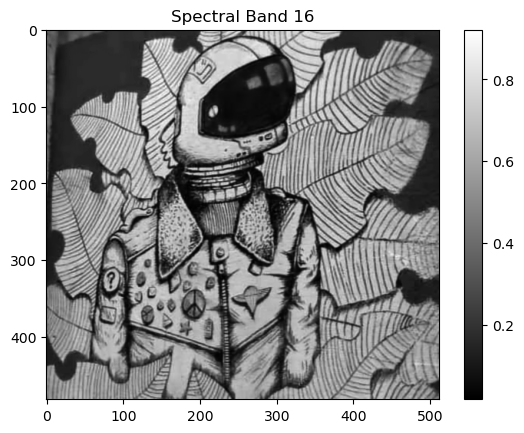

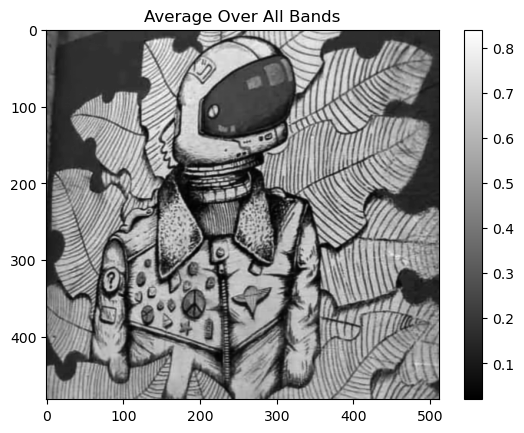

In [11]:
#| eval: false
import h5py
import numpy as np
import matplotlib.pyplot as plt

def load_and_visualize_mat_v7_3(file_path):
    try:
        # Load the .mat file
        with h5py.File(file_path, 'r') as mat_file:
            # Extract the 'cube' dataset
            cube = mat_file['cube'][()]  # Load the full dataset into a NumPy array
            
            # Check the shape of the data cube
            print(f"Data cube shape: {cube.shape}")

            # Visualize one of the spectral bands (e.g., the 15th band)
            band_index = 15  # Choose a band to visualize
            if band_index < cube.shape[0]:
                band_data = cube[band_index, :, :]
                band_data_corrected = np.transpose(band_data)  # Correct rotation
                
                plt.imshow(band_data_corrected, cmap='gray')
                plt.title(f'Spectral Band {band_index + 1}')
                plt.colorbar()
                plt.show()
            else:
                print(f"Band index {band_index} is out of range for cube with shape {cube.shape}")

            # Visualize an average over all bands (create an RGB-like view)
            average_band = np.mean(cube, axis=0)
            average_band_corrected = np.transpose(average_band)  # Correct rotation
            
            plt.imshow(average_band_corrected, cmap='gray')
            plt.title('Average Over All Bands')
            plt.colorbar()
            plt.show()

    except FileNotFoundError:
        print("The specified file was not found. Please check the file path.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Replace with the path to your .mat file
file_path = "./visualization/simulation_results/results/mst_plus_plus.mat"
load_and_visualize_mat_v7_3(file_path)


## 6. Evaluation on the Validation Set:

(1) Download the pretrained model zoo from (Google Drive / Baidu Disk, code: mst1) and place them to /MST-plus-plus/test_develop_code/model_zoo/.

(2) Run the following command to test the model on the validation RGB images.



In [23]:
#| eval: false
cd test_develop_code


/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/test_develop_code


In [24]:
#| eval: false
ls

__pycache__/   exp/            model_zoo/  utils.py
architecture/  hsi_dataset.py  test.py


#### Test MST++


In [28]:
#| eval: false
!python test.py --data_root ../dataset/  --method mst_plus_plus --pretrained_model_path ./model_zoo/mst_plus_plus.pth --outf ./exp/mst_plus_plus/  --gpu_id 0

len(hyper_valid) of ntire2022 dataset:50
len(bgr_valid) of ntire2022 dataset:50
Ntire2022 scene 0 is loaded.
Ntire2022 scene 1 is loaded.
Ntire2022 scene 2 is loaded.
Ntire2022 scene 3 is loaded.
Ntire2022 scene 4 is loaded.
Ntire2022 scene 5 is loaded.
Ntire2022 scene 6 is loaded.
Ntire2022 scene 7 is loaded.
Ntire2022 scene 8 is loaded.
Ntire2022 scene 9 is loaded.
Ntire2022 scene 10 is loaded.
Ntire2022 scene 11 is loaded.
Ntire2022 scene 12 is loaded.
Ntire2022 scene 13 is loaded.
Ntire2022 scene 14 is loaded.
Ntire2022 scene 15 is loaded.
Ntire2022 scene 16 is loaded.
Ntire2022 scene 17 is loaded.
Ntire2022 scene 18 is loaded.
Ntire2022 scene 19 is loaded.
Ntire2022 scene 20 is loaded.
Ntire2022 scene 21 is loaded.
Ntire2022 scene 22 is loaded.
Ntire2022 scene 23 is loaded.
Ntire2022 scene 24 is loaded.
Ntire2022 scene 25 is loaded.
Ntire2022 scene 26 is loaded.
Ntire2022 scene 27 is loaded.
Ntire2022 scene 28 is loaded.
Ntire2022 scene 29 is loaded.
Ntire2022 scene 30 is loaded.


#### Test HSCNN+

In [39]:
#| eval: false
!python test.py --data_root ../dataset/  --method hscnn_plus --pretrained_model_path ./model_zoo/hscnn_plus.pth --outf ./exp/hscnn_plus/  --gpu_id 0


len(hyper_valid) of ntire2022 dataset:50
len(bgr_valid) of ntire2022 dataset:50
Ntire2022 scene 0 is loaded.
Ntire2022 scene 1 is loaded.
Ntire2022 scene 2 is loaded.
Ntire2022 scene 3 is loaded.
Ntire2022 scene 4 is loaded.
Ntire2022 scene 5 is loaded.
Ntire2022 scene 6 is loaded.
Ntire2022 scene 7 is loaded.
Ntire2022 scene 8 is loaded.
Ntire2022 scene 9 is loaded.
Ntire2022 scene 10 is loaded.
Ntire2022 scene 11 is loaded.
Ntire2022 scene 12 is loaded.
Ntire2022 scene 13 is loaded.
Ntire2022 scene 14 is loaded.
Ntire2022 scene 15 is loaded.
Ntire2022 scene 16 is loaded.
Ntire2022 scene 17 is loaded.
Ntire2022 scene 18 is loaded.
Ntire2022 scene 19 is loaded.
Ntire2022 scene 20 is loaded.
Ntire2022 scene 21 is loaded.
Ntire2022 scene 22 is loaded.
Ntire2022 scene 23 is loaded.
Ntire2022 scene 24 is loaded.
Ntire2022 scene 25 is loaded.
Ntire2022 scene 26 is loaded.
Ntire2022 scene 27 is loaded.
Ntire2022 scene 28 is loaded.
Ntire2022 scene 29 is loaded.
Ntire2022 scene 30 is loaded.


#### Test HDNet

In [37]:
#| eval: false
!python test.py --data_root ../dataset/  --method hdnet --pretrained_model_path ./model_zoo/hdnet.pth --outf ./exp/hdnet/  --gpu_id 0


len(hyper_valid) of ntire2022 dataset:50
len(bgr_valid) of ntire2022 dataset:50
Ntire2022 scene 0 is loaded.
Ntire2022 scene 1 is loaded.
Ntire2022 scene 2 is loaded.
Ntire2022 scene 3 is loaded.
Ntire2022 scene 4 is loaded.
Ntire2022 scene 5 is loaded.
Ntire2022 scene 6 is loaded.
Ntire2022 scene 7 is loaded.
Ntire2022 scene 8 is loaded.
Ntire2022 scene 9 is loaded.
Ntire2022 scene 10 is loaded.
Ntire2022 scene 11 is loaded.
Ntire2022 scene 12 is loaded.
Ntire2022 scene 13 is loaded.
Ntire2022 scene 14 is loaded.
Ntire2022 scene 15 is loaded.
Ntire2022 scene 16 is loaded.
Ntire2022 scene 17 is loaded.
Ntire2022 scene 18 is loaded.
Ntire2022 scene 19 is loaded.
Ntire2022 scene 20 is loaded.
Ntire2022 scene 21 is loaded.
Ntire2022 scene 22 is loaded.
Ntire2022 scene 23 is loaded.
Ntire2022 scene 24 is loaded.
Ntire2022 scene 25 is loaded.
Ntire2022 scene 26 is loaded.
Ntire2022 scene 27 is loaded.
Ntire2022 scene 28 is loaded.
Ntire2022 scene 29 is loaded.
Ntire2022 scene 30 is loaded.


## Traning 

In [45]:
#| eval: false
cd train_code/


/root/Ninjalabo/HSI/MST-plus-plus/MST-plus-plus/train_code


In [48]:
#| eval: false
# !python train.py --method mst_plus_plus  --batch_size 20 --end_epoch 300 --init_lr 4e-4 --outf ./exp/mst_plus_plus/ --data_root ../dataset/  --patch_size 128 --stride 8  --gpu_id 0

## Supported Algorithms:
* Figure: PSNR-Params-FLOPS comparisons with other spectral reconstruction algorithms. 
* FLOPS (Floating Point Operations Per Second): computational complexity
* PSNR ( Peak signal-to-noise ratio): performance
* The circle radius is Params: memory cost
* MST++: surpasses other methods while requiring significantly cheaper FLOPS and Params.

![](images/compare_fig.png)

## Comparison with Other Methods

* MST++ achieved the highest PSNR of 34.32 dB on the validation set, a significant improvement over previous methods.
* In terms of efficiency, MST++ required only 23.05 FLOPS, making it one of the most lightweight models.
* MST++ achieved the lowest error rates- RMSE (root mean square error), and MRAE (mean relative absolute error).


![](images/Validation.png)


## Experiment Results
The dataset for evaluation consisted of RGB-HSI pairs with 31 spectral bands.
#### Quantitative Results:
* MST++ outperformed all other models in metrics like PSNR, RMSE, and MRAE.
#### Qualitative Results:
* Visual comparisons show that MST++ produces sharper, more detailed hyperspectral reconstructions with fewer artifacts.
* It excels in preserving spatial smoothness and restoring spectral consistency.

